Generate Data

In [120]:
import numpy as np
import pandas as pd

num_samples = 50
num_modes = 2
mu = [-2, 0]
sigma = [1, 0.3]
samples = np.zeros(num_samples)

which_mode = np.random.multinomial(1, [1/num_modes]*num_modes, size = num_samples)

for idx_mode in range(num_modes):
    samples_mode = np.random.normal(loc = mu[idx_mode], scale = sigma[idx_mode], size = num_samples) * which_mode[:,idx_mode]
    samples = samples + samples_mode
pd.DataFrame(samples).to_csv("samples_1.csv")

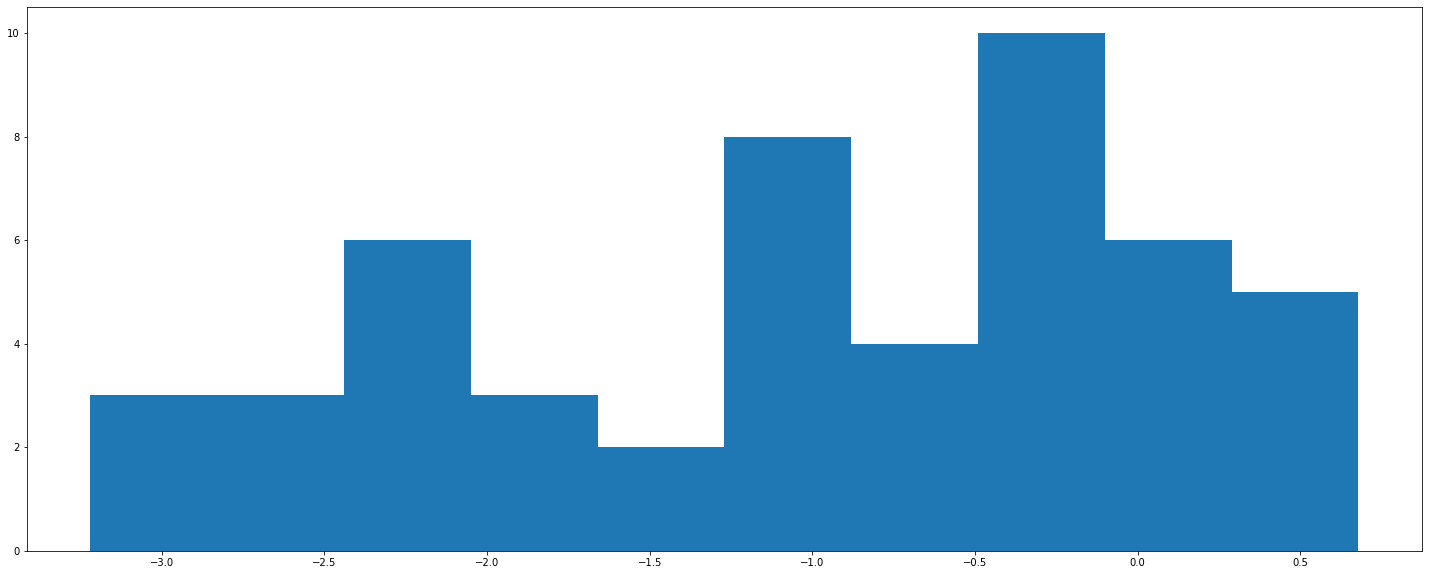

In [123]:
import matplotlib.pyplot as plt

samples = pd.read_csv("samples_1.csv").set_index("Unnamed: 0").to_numpy()

_ = plt.hist(samples, bins = 10)

Inference - MCMC

Priors:
- mean: Normal(0, 10)
- Sigma: Gamma(1,1)

sample mean tf.Tensor([1. 1. 2. 1.], shape=(4,), dtype=float32)
sample standard deviation tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)


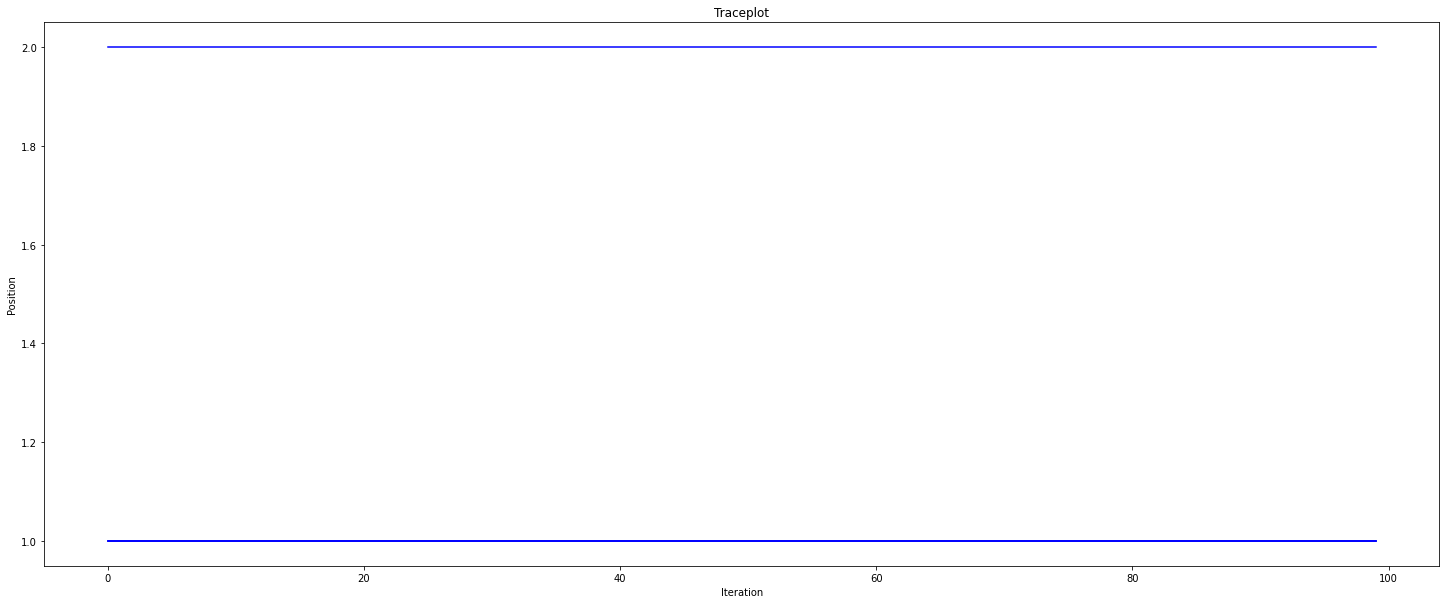

In [174]:
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import math

tfd = tfp.distributions
dtype = np.float32
data = pd.read_csv("samples_1.csv").set_index("Unnamed: 0").to_numpy()


def target_log_prob(param):
    mu_1, mu_2, sigma_1, sigma_2 = param
    # dens = mu_1 + mu_2
    dens = tf.math.reduce_sum(tf.math.log(
        1/(2*tf.math.sqrt(2*math.pi*sigma_1**2)) * tf.math.exp(-(data - mu_1)**2/sigma_1**2) + 
        1/(2*tf.math.sqrt(2*math.pi*sigma_2**2)) * tf.math.exp(-(data - mu_2)**2/sigma_2**2))) - 0.5 * (mu_1**2 + mu_2**2) - (sigma_1 + sigma_2)
    return(dens)

# Define MALA sampler with `step_size` equal to 0.75
samples = tfp.mcmc.sample_chain(
    num_results=100,
    current_state=dtype([1, 1, 2, 1]),
    kernel=tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
        target_log_prob_fn=target_log_prob,
        step_size=0.75),
    num_burnin_steps=50,
    trace_fn=None,
    seed=42)

sample_mean = tf.reduce_mean(samples, axis=0)
sample_std = tf.sqrt(
    tf.reduce_mean(
        tf.math.squared_difference(samples, sample_mean),
        axis=0))

print('sample mean', sample_mean)
print('sample standard deviation', sample_std)

plt.title('Traceplot')
plt.plot(samples.numpy(), 'b')
plt.xlabel('Iteration')
plt.ylabel('Position')
plt.show()


In [39]:

def target_log_prob(param):
    mu_1, mu_2, sigma_1, sigma_2 = param
    dens = np.sum(np.log(
        1/(2*np.sqrt(2*math.pi*sigma_1**2)) * np.exp(-(data - mu_1)**2/sigma_1**2) + 
        1/(2*np.sqrt(2*math.pi*sigma_2**2)) * np.exp(-(data - mu_2)**2/sigma_2**2))) - 1/2 * (mu_1**2 + mu_2**2) - (sigma_1 + sigma_2)
    return(dens)

In [154]:
import matplotlib.pyplot as plt
mean = [0, 0, 0, 0]

cov = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]  # diagonal covariance
samples = np.random.multivariate_normal(mean, cov, 1)

# plt.plot(x, y, 'x')

# plt.axis('equal')

# plt.show()

In [155]:
samples[0]

array([-0.18222145,  2.64557046, -0.76927536,  0.44755414])

In [151]:
np.array([[1, 1, 1, 1]])

array([[1, 1, 1, 1]])

In [172]:
import numpy as np
import math

data = pd.read_csv("samples_1.csv").set_index("Unnamed: 0").to_numpy()


def target_prob(param):
    mu_1, mu_2, sigma_1, sigma_2 = param

    if sigma_1 <= 0 or sigma_2 <= 0:
        dens = 0
    else:
        dens = np.exp(np.sum(np.log(
                1/(2*np.sqrt(2*math.pi*sigma_1**2)) * np.exp(-(data - mu_1)**2/sigma_1**2) + 
                1/(2*np.sqrt(2*math.pi*sigma_2**2)) * np.exp(-(data - mu_2)**2/sigma_2**2))) - 1/2 * (mu_1**2 + mu_2**2) - (sigma_1 + sigma_2))
    
    return(dens)

def target_log_prob(param):
    mu_1, mu_2, sigma_1, sigma_2 = param

    if sigma_1 <= 0 or sigma_2 <= 0:
        dens = -np.Inf
    else:
        dens = np.sum(np.log(
                1/(2*np.sqrt(2*math.pi*sigma_1**2)) * np.exp(-(data - mu_1)**2/sigma_1**2) + 
                1/(2*np.sqrt(2*math.pi*sigma_2**2)) * np.exp(-(data - mu_2)**2/sigma_2**2))) - 1/2 * (mu_1**2 + mu_2**2) - (sigma_1 + sigma_2)
    
    return(dens)


num_samples = 5
samples = []
# x_init = [1, 1, 1, 1]
x_init = np.array([1, 1, 1, 1])
x_curr = x_init
acc_count = 0
for t in range(num_samples):
    unit_cov = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
    x_prop = np.random.multivariate_normal(x_curr, cov, 1)[0]
    # x_prop = np.random.normal(loc = x_curr, scale = 0.25)


    alpha = target_log_prob(x_prop)/target_log_prob(x_curr)

    print(f"Proposal: {x_prop}")
    print(f"Density Proposal: {target_log_prob(x_prop)}")
    print(f"Density Current: {target_log_prob(x_curr)}")
    print(f"alpha: {alpha}")  

    u = np.random.random(size = 1)

    if u <= alpha and target_log_prob(x_prop) != -np.Inf:
        x_curr = x_prop
        acc_count += 1
      
    print(f"acc_count: {acc_count}")
    samples.append(x_curr)

print(f"Acceptance Rate: {round(acc_count/num_samples, 2)}")

Proposal: [ 1.35801097 -0.1506456   0.52076493 -0.36216725]
Density Proposal: -inf
Density Current: -311.39958273080055
alpha: inf
acc_count: 0
Proposal: [0.00258401 0.47913787 1.18433526 1.54309587]
Density Proposal: -137.59288406350933
Density Current: -311.39958273080055
alpha: 0.44185314205271736
acc_count: 0
Proposal: [0.572559   1.8701054  1.42982522 0.57738593]
Density Proposal: -192.92216442367913
Density Current: -311.39958273080055
alpha: 0.6195325078211712
acc_count: 0
Proposal: [ 0.95113189 -0.27016784  2.06331475 -0.1485911 ]
Density Proposal: -inf
Density Current: -311.39958273080055
alpha: inf
acc_count: 0
Proposal: [3.01866447 2.00434711 0.31881114 1.19840404]
Density Proposal: -457.00285132584037
Density Current: -311.39958273080055
alpha: 1.4675769547222268
acc_count: 1
Acceptance Rate: 0.2


In [158]:
target_log_prob(x_init)

-311.39958273080055

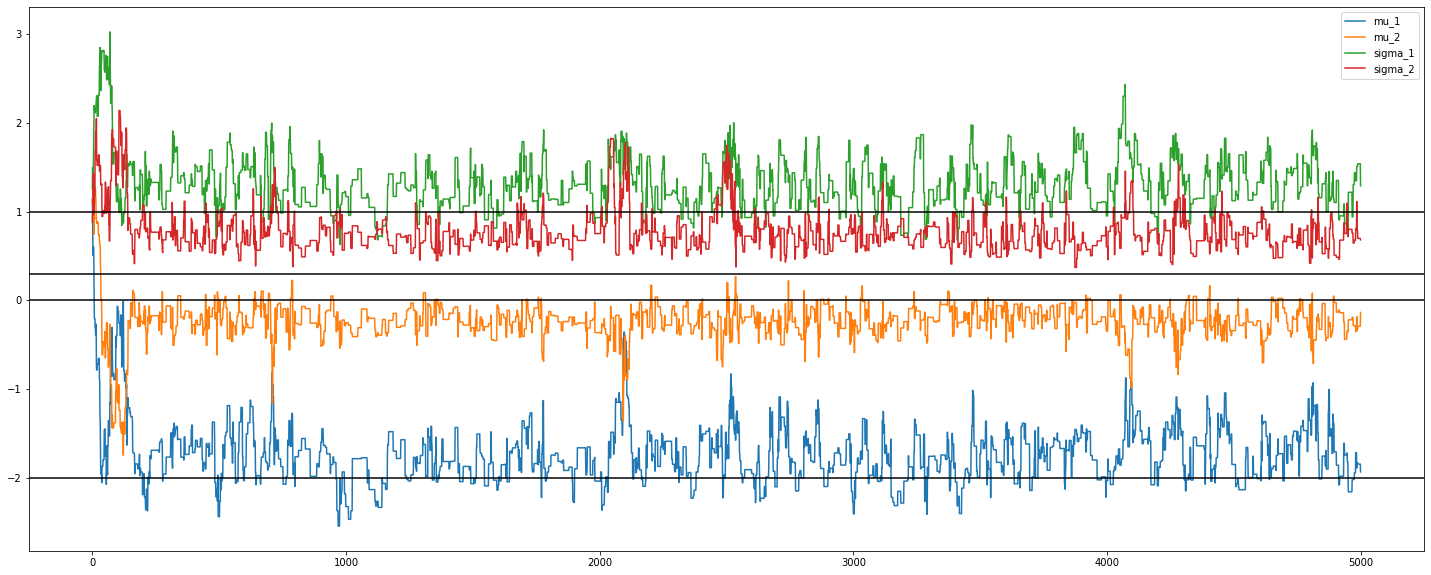

In [127]:
import matplotlib.pyplot as plt

_ = plt.plot(samples)
plt.legend(["mu_1", "mu_2", "sigma_1", "sigma_2"])
plt.rcParams["figure.figsize"] = (25,10)
plt.axhline(y=-2, color='black', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=0.3, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')

mu = [-2, 0]
sigma = [1, 0.3]